In [25]:
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
sys.path.insert(1, '/home/jupyter/ds_toolkit')
from ds_toolkit import tools
from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

In [28]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [231]:
dataset = pd.read_csv('timeseries_data.csv',parse_dates=['usage_date'],index_col='usage_date')

In [232]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1602 entries, 2016-01-02 00:00:00+00:00 to 2020-05-24 00:00:00+00:00
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1602 non-null   int64  
 1   acct_ttl_unit_hours  1602 non-null   float64
 2   z5                   1602 non-null   float64
 3   z10                  1602 non-null   float64
 4   z15                  1602 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 75.1 KB


In [233]:
dataset.head()

,Unnamed: 0,acct_ttl_unit_hours,z5,z10,z15
usage_date,,,,,
2016-01-02 00:00:00+00:00,0,13920.0,0.0,0.0,0.0
2016-01-03 00:00:00+00:00,1,13920.0,0.0,0.0,0.0
2016-01-04 00:00:00+00:00,2,13920.0,0.0,0.0,0.0
2016-01-05 00:00:00+00:00,3,13920.0,0.0,0.0,0.0
2016-01-06 00:00:00+00:00,4,13920.0,0.0,0.0,0.0


In [234]:
#define parameter of interest
#poi = 'acct_ttl_unit_hours'
poi = 'z5'
#poi = 'z10'
#poi = 'z15'

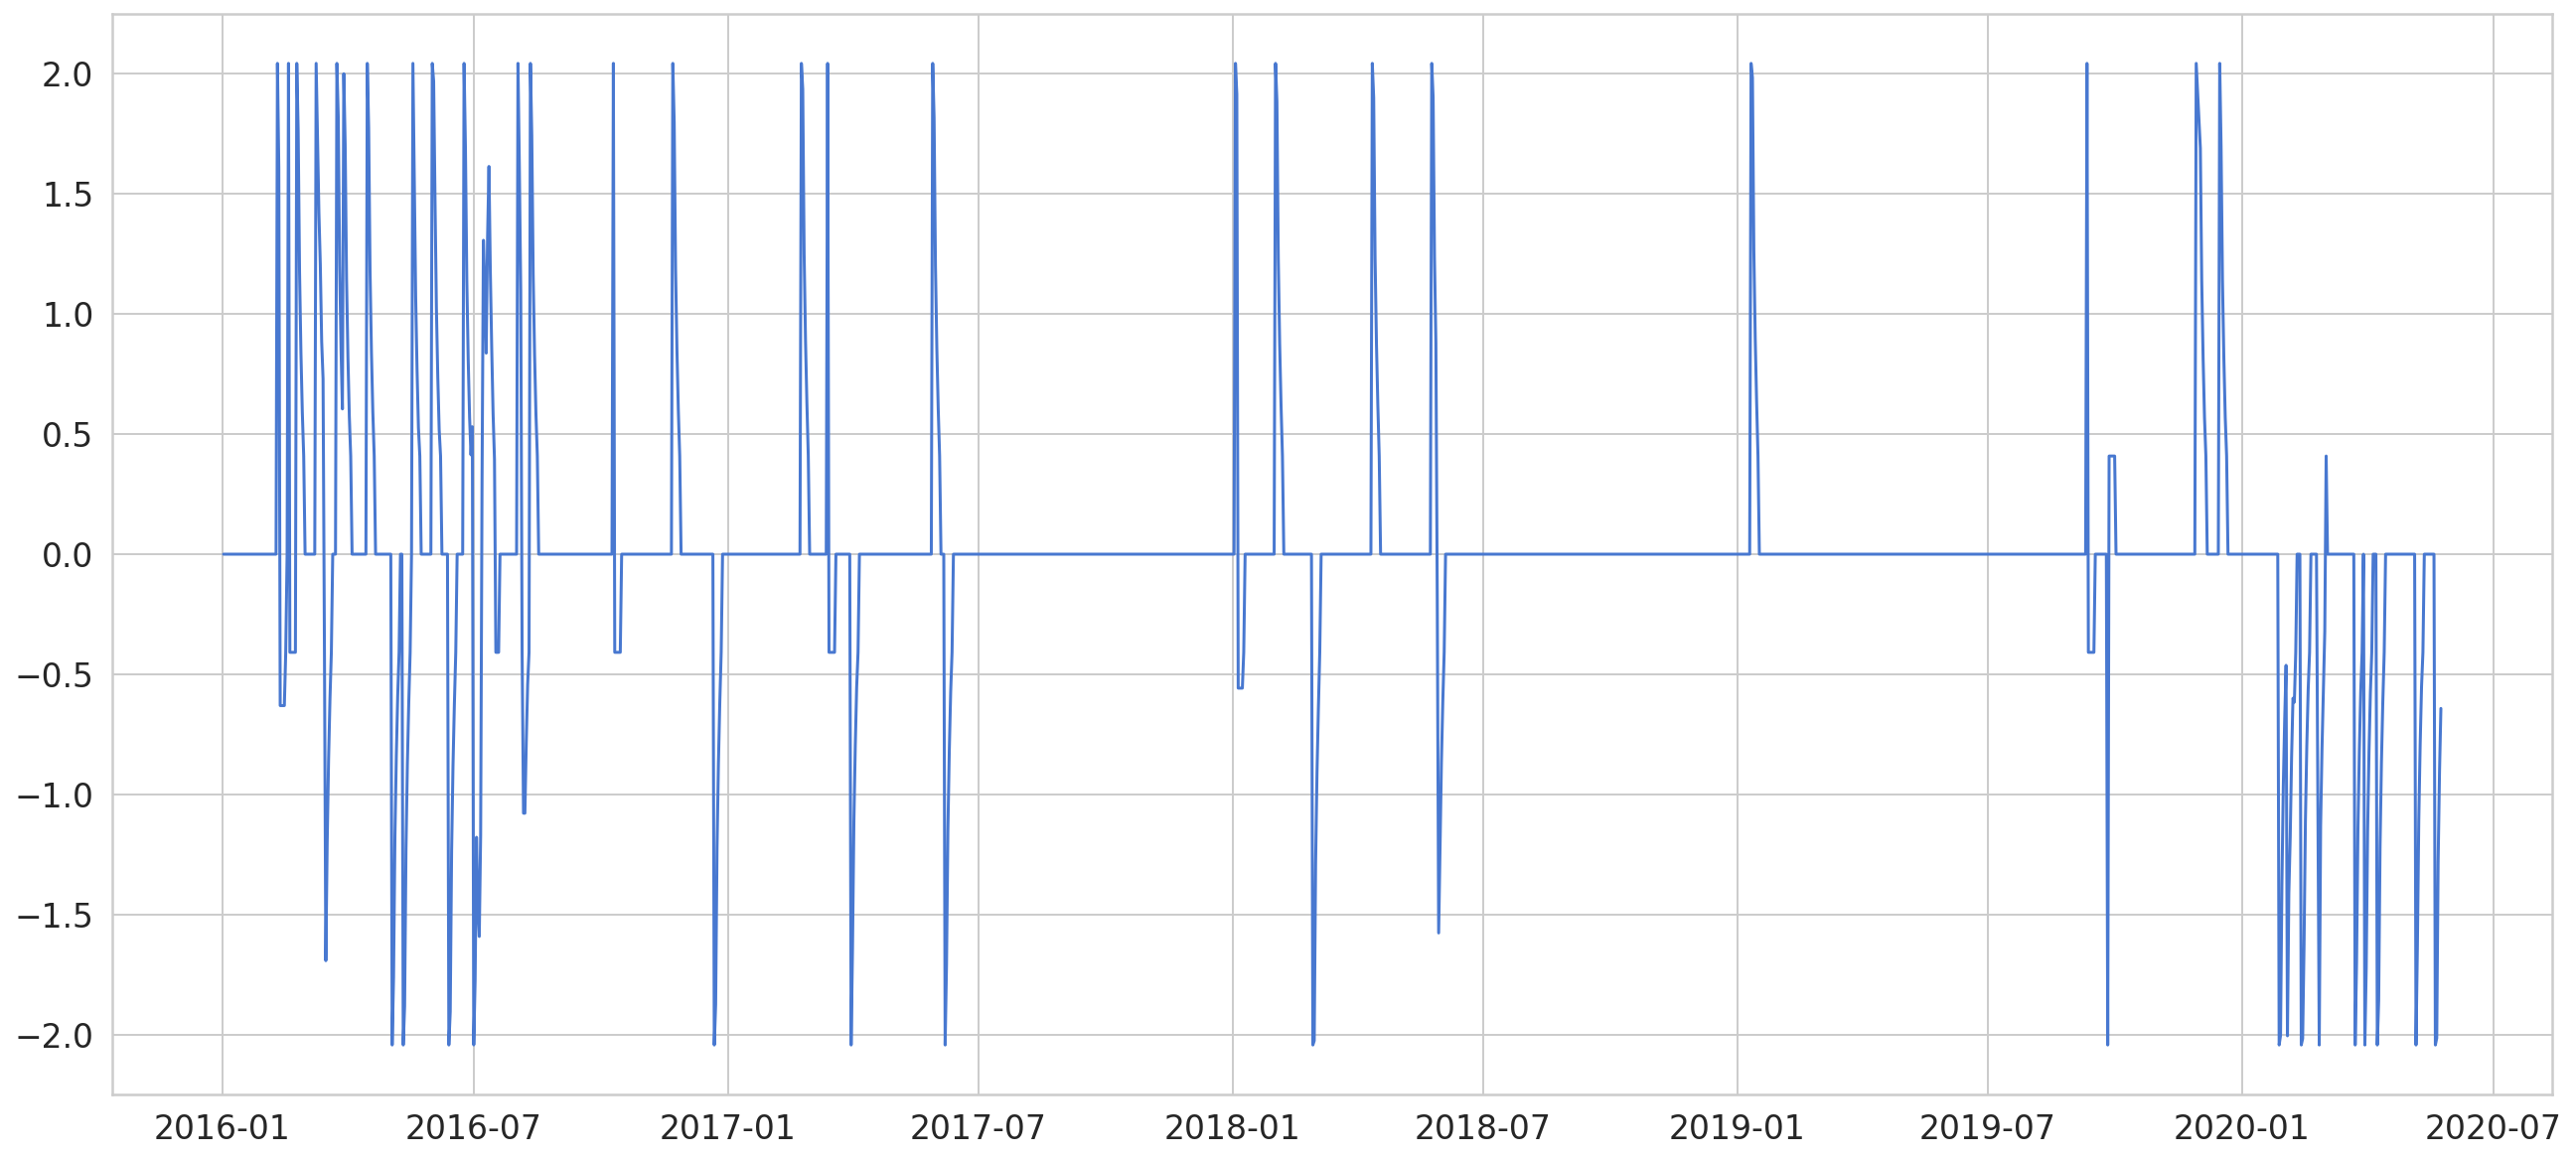

In [235]:
plt.plot(dataset.index,dataset[poi])

## split the data

In [236]:
train_size = int(len(dataset)*0.5)
test_size = len(dataset) - train_size

train, test = dataset.iloc[0:train_size],dataset.iloc[train_size:len(dataset)]
print(train.shape,test.shape)

(801, 5) (801, 5)


## scale the data

In [237]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[[poi]])

In [238]:
#apply transformation
train[poi] = scaler.transform(train[[poi]])
test[poi] = scaler.transform(test[[poi]])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [239]:
def create_dataset(X,y,time_steps=1):
    Xs, ys = [],[]
    for i in range(len(X)-time_steps):
        v=X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [240]:
TIME_STEPS = 5

X_train, y_train = create_dataset(train[[poi]],train[poi],TIME_STEPS)
X_test, y_test = create_dataset(test[[poi]],test[poi],TIME_STEPS)

In [241]:
X_train.shape

(796, 5, 1)

# LSTM Autoencoder

In [242]:
#idea use LSTM to fit time series, when error(pred-actual) exceeds a threshold, label as anomaly

In [260]:
model = keras.Sequential()

#first layer
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1],X_train.shape[2])
))

#add regularization layer
model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

model.add(keras.layers.LSTM(
    units=64,
    return_sequences=True
))

#add another regularization layer
model.add(keras.layers.Dropout(rate=0.2))

#add time-distributed layer for anomaly detection
model.add(keras.layers.TimeDistributed(keras.layers.Dense(
   units=X_train.shape[2]
)))

model.compile(loss='mae', optimizer='adam')

Epoch 1/16
23/23 [==============================] - 1s 45ms/step - loss: 0.4140 - val_loss: 0.4154
Epoch 2/16
23/23 [==============================] - 0s 11ms/step - loss: 0.3596 - val_loss: 0.3650
Epoch 3/16
23/23 [==============================] - 0s 11ms/step - loss: 0.3178 - val_loss: 0.3328
Epoch 4/16
23/23 [==============================] - 0s 11ms/step - loss: 0.2921 - val_loss: 0.3200
Epoch 5/16
23/23 [==============================] - 0s 12ms/step - loss: 0.2811 - val_loss: 0.3066
Epoch 6/16
23/23 [==============================] - 0s 11ms/step - loss: 0.2714 - val_loss: 0.2954
Epoch 7/16
23/23 [==============================] - 0s 11ms/step - loss: 0.2608 - val_loss: 0.2843
Epoch 8/16
23/23 [==============================] - 0s 11ms/step - loss: 0.2492 - val_loss: 0.2707
Epoch 9/16
23/23 [==============================] - 0s 10ms/step - loss: 0.2396 - val_loss: 0.2644
Epoch 10/16
23/23 [==============================] - 0s 12ms/step - loss: 0.2359 - val_loss: 0.2583
Epoch 11/

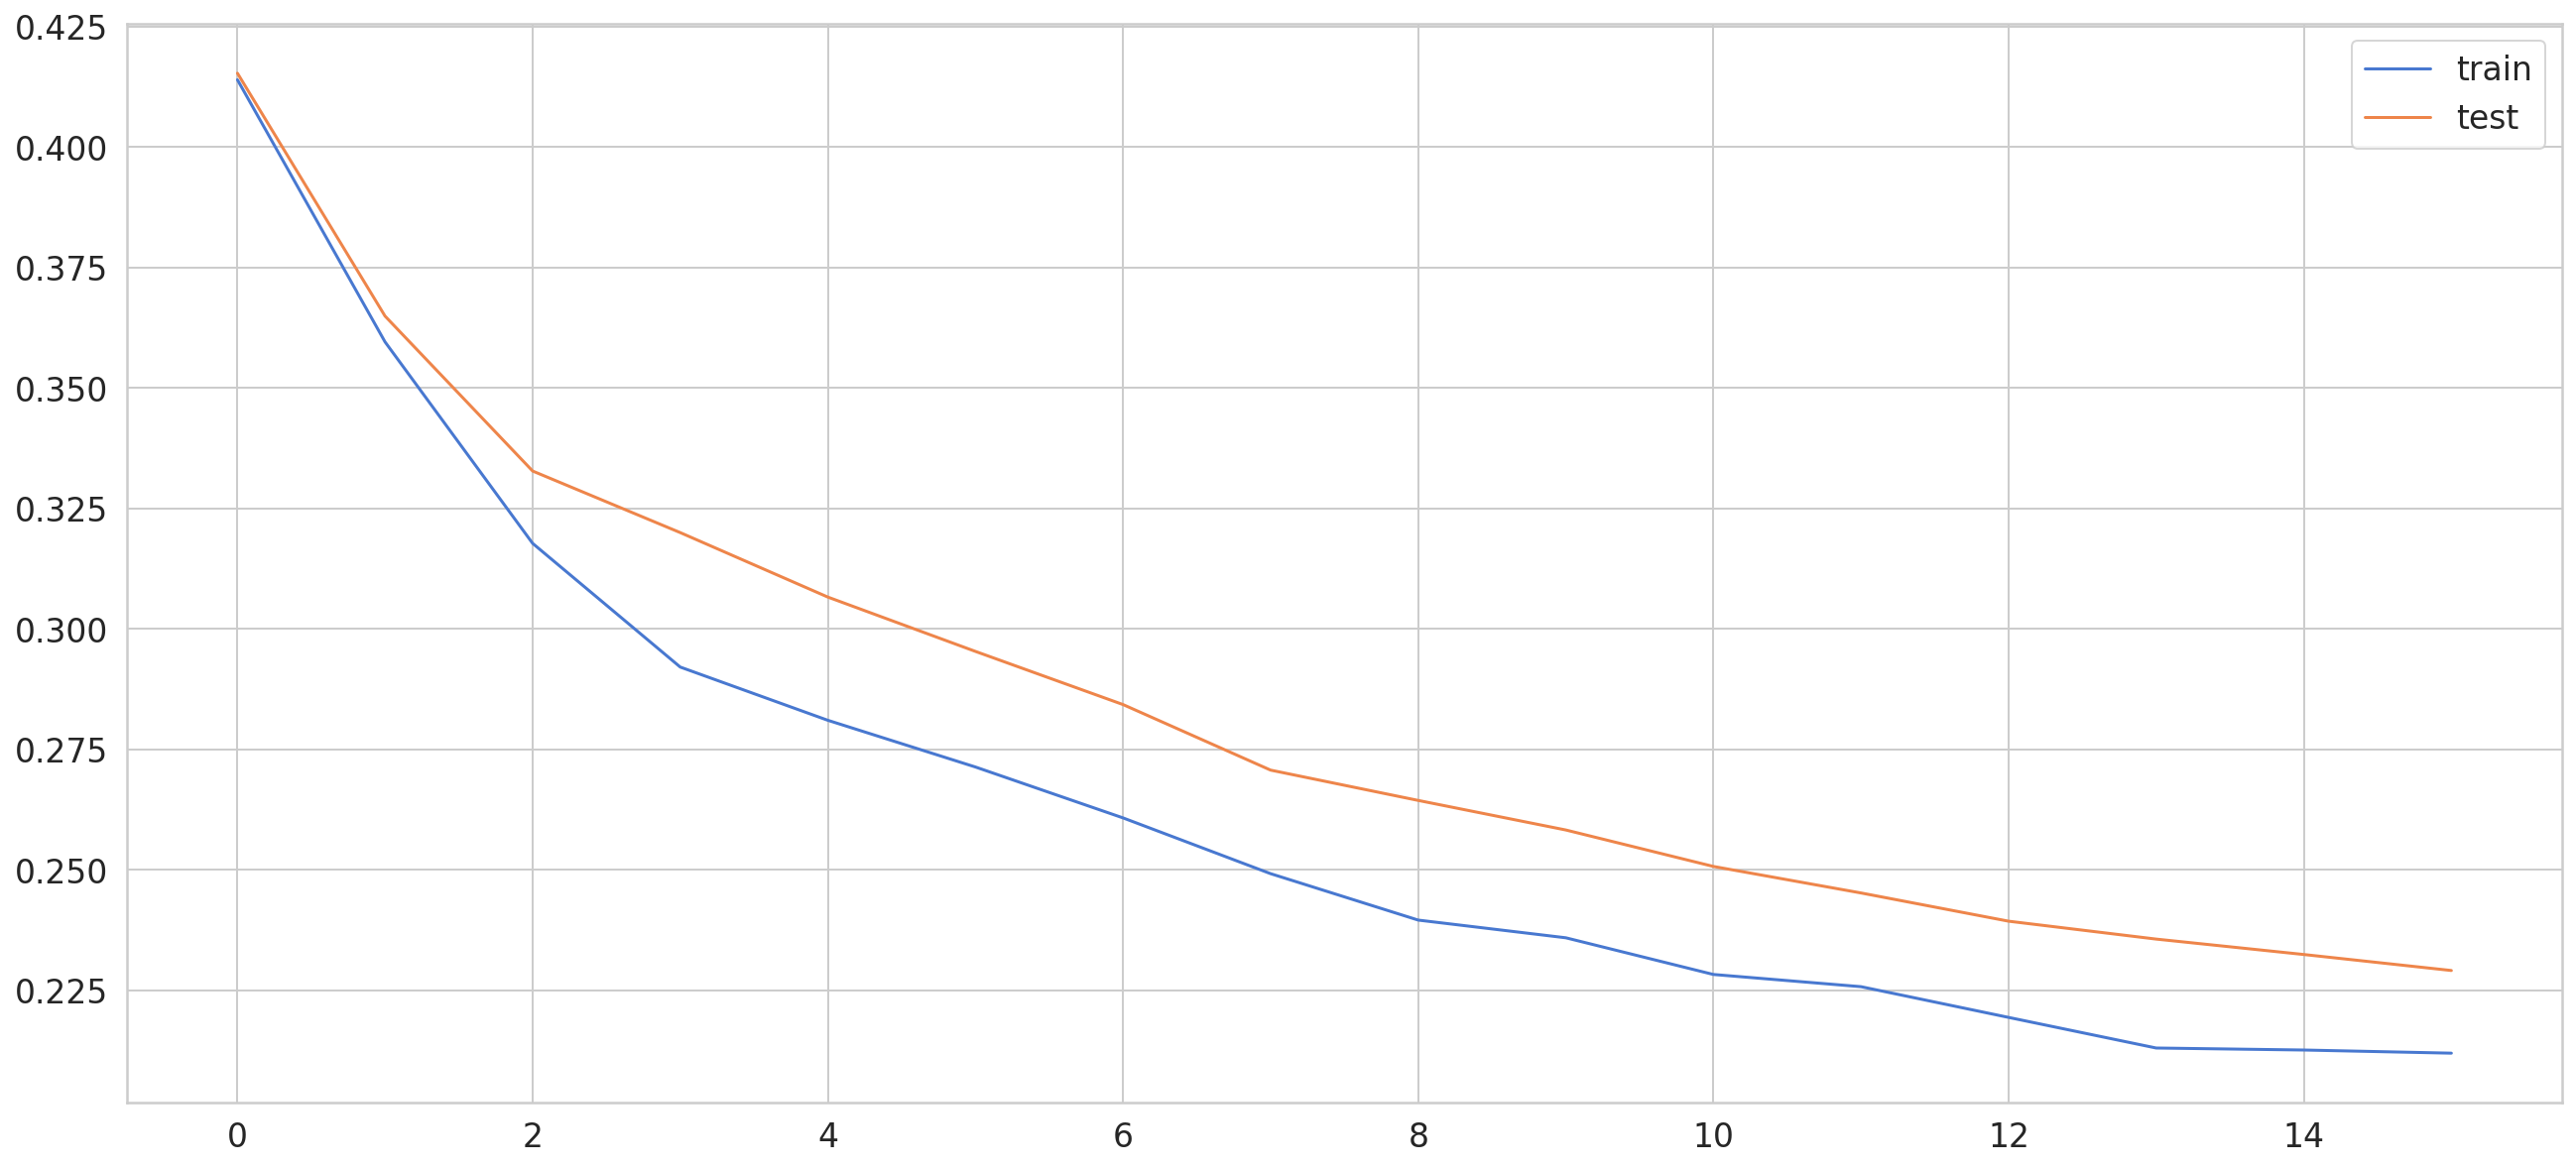

In [261]:
history = model.fit(
    X_train, y_train,
    epochs=16,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
    )
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend();

In [263]:
X_train_pred = model.predict(X_train)

In [264]:
train_mae_loss = np.mean(np.abs(X_train_pred,X_train),axis=1)

In [265]:
train_mae_loss.shape

(796, 1)

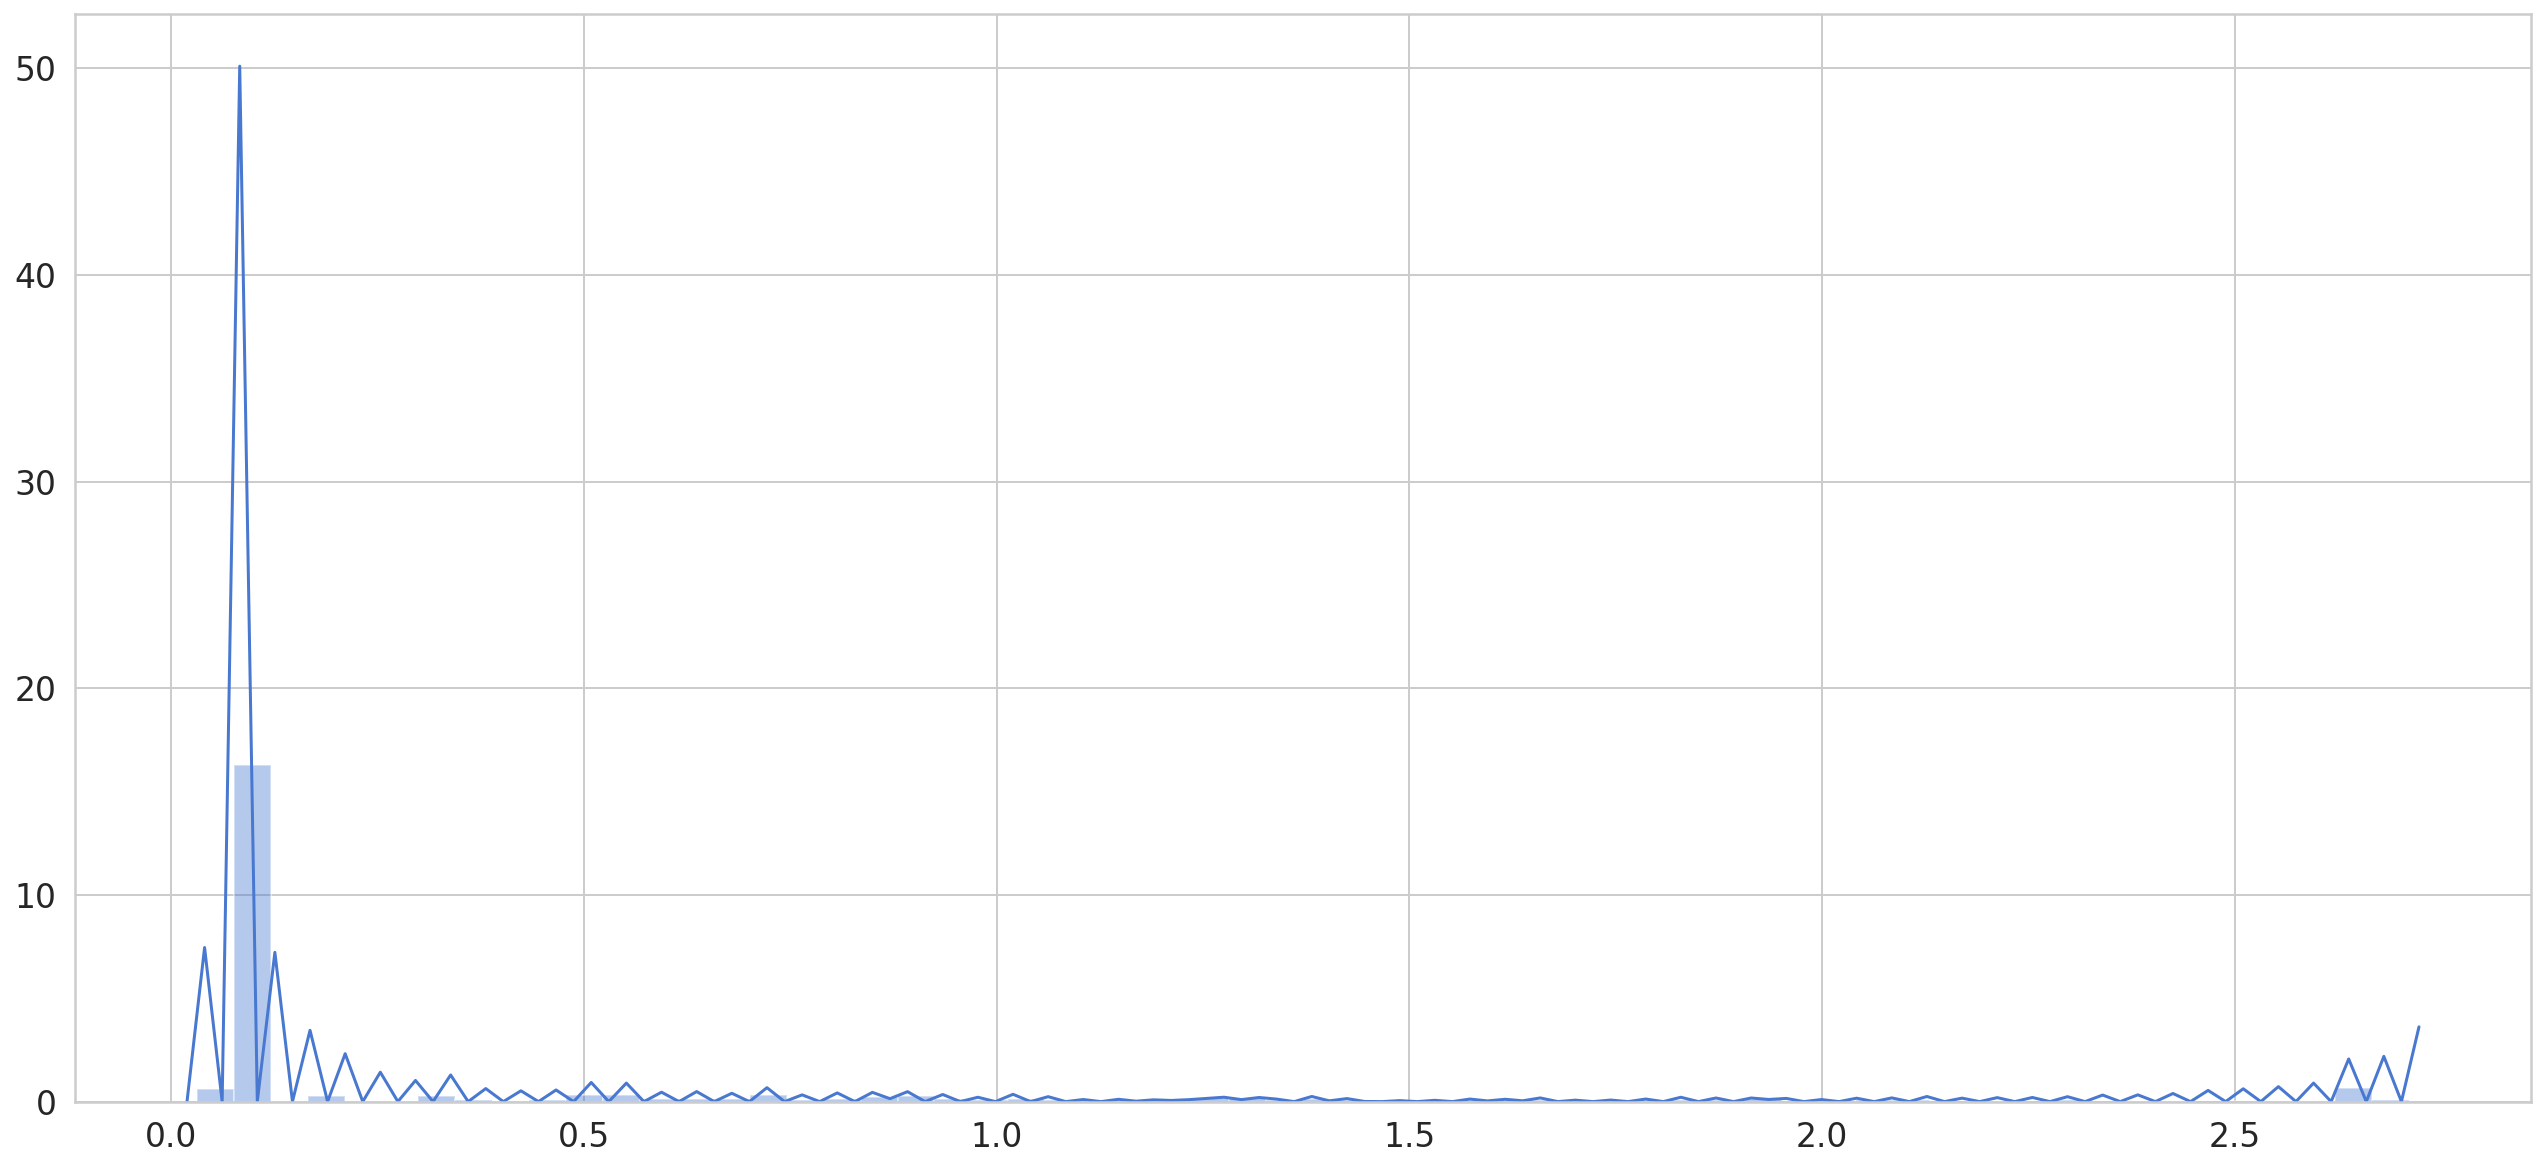

In [266]:
sns.distplot(train_mae_loss,bins=60,kde=True)

In [165]:
### Do the same for the test set

In [267]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred,X_test),axis=1)

In [268]:
THRESHOLD = 0.5

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df[poi] = test[TIME_STEPS:][poi]
#
test_score_df['acct_ttl_unit_hours']=test[TIME_STEPS:]['acct_ttl_unit_hours']

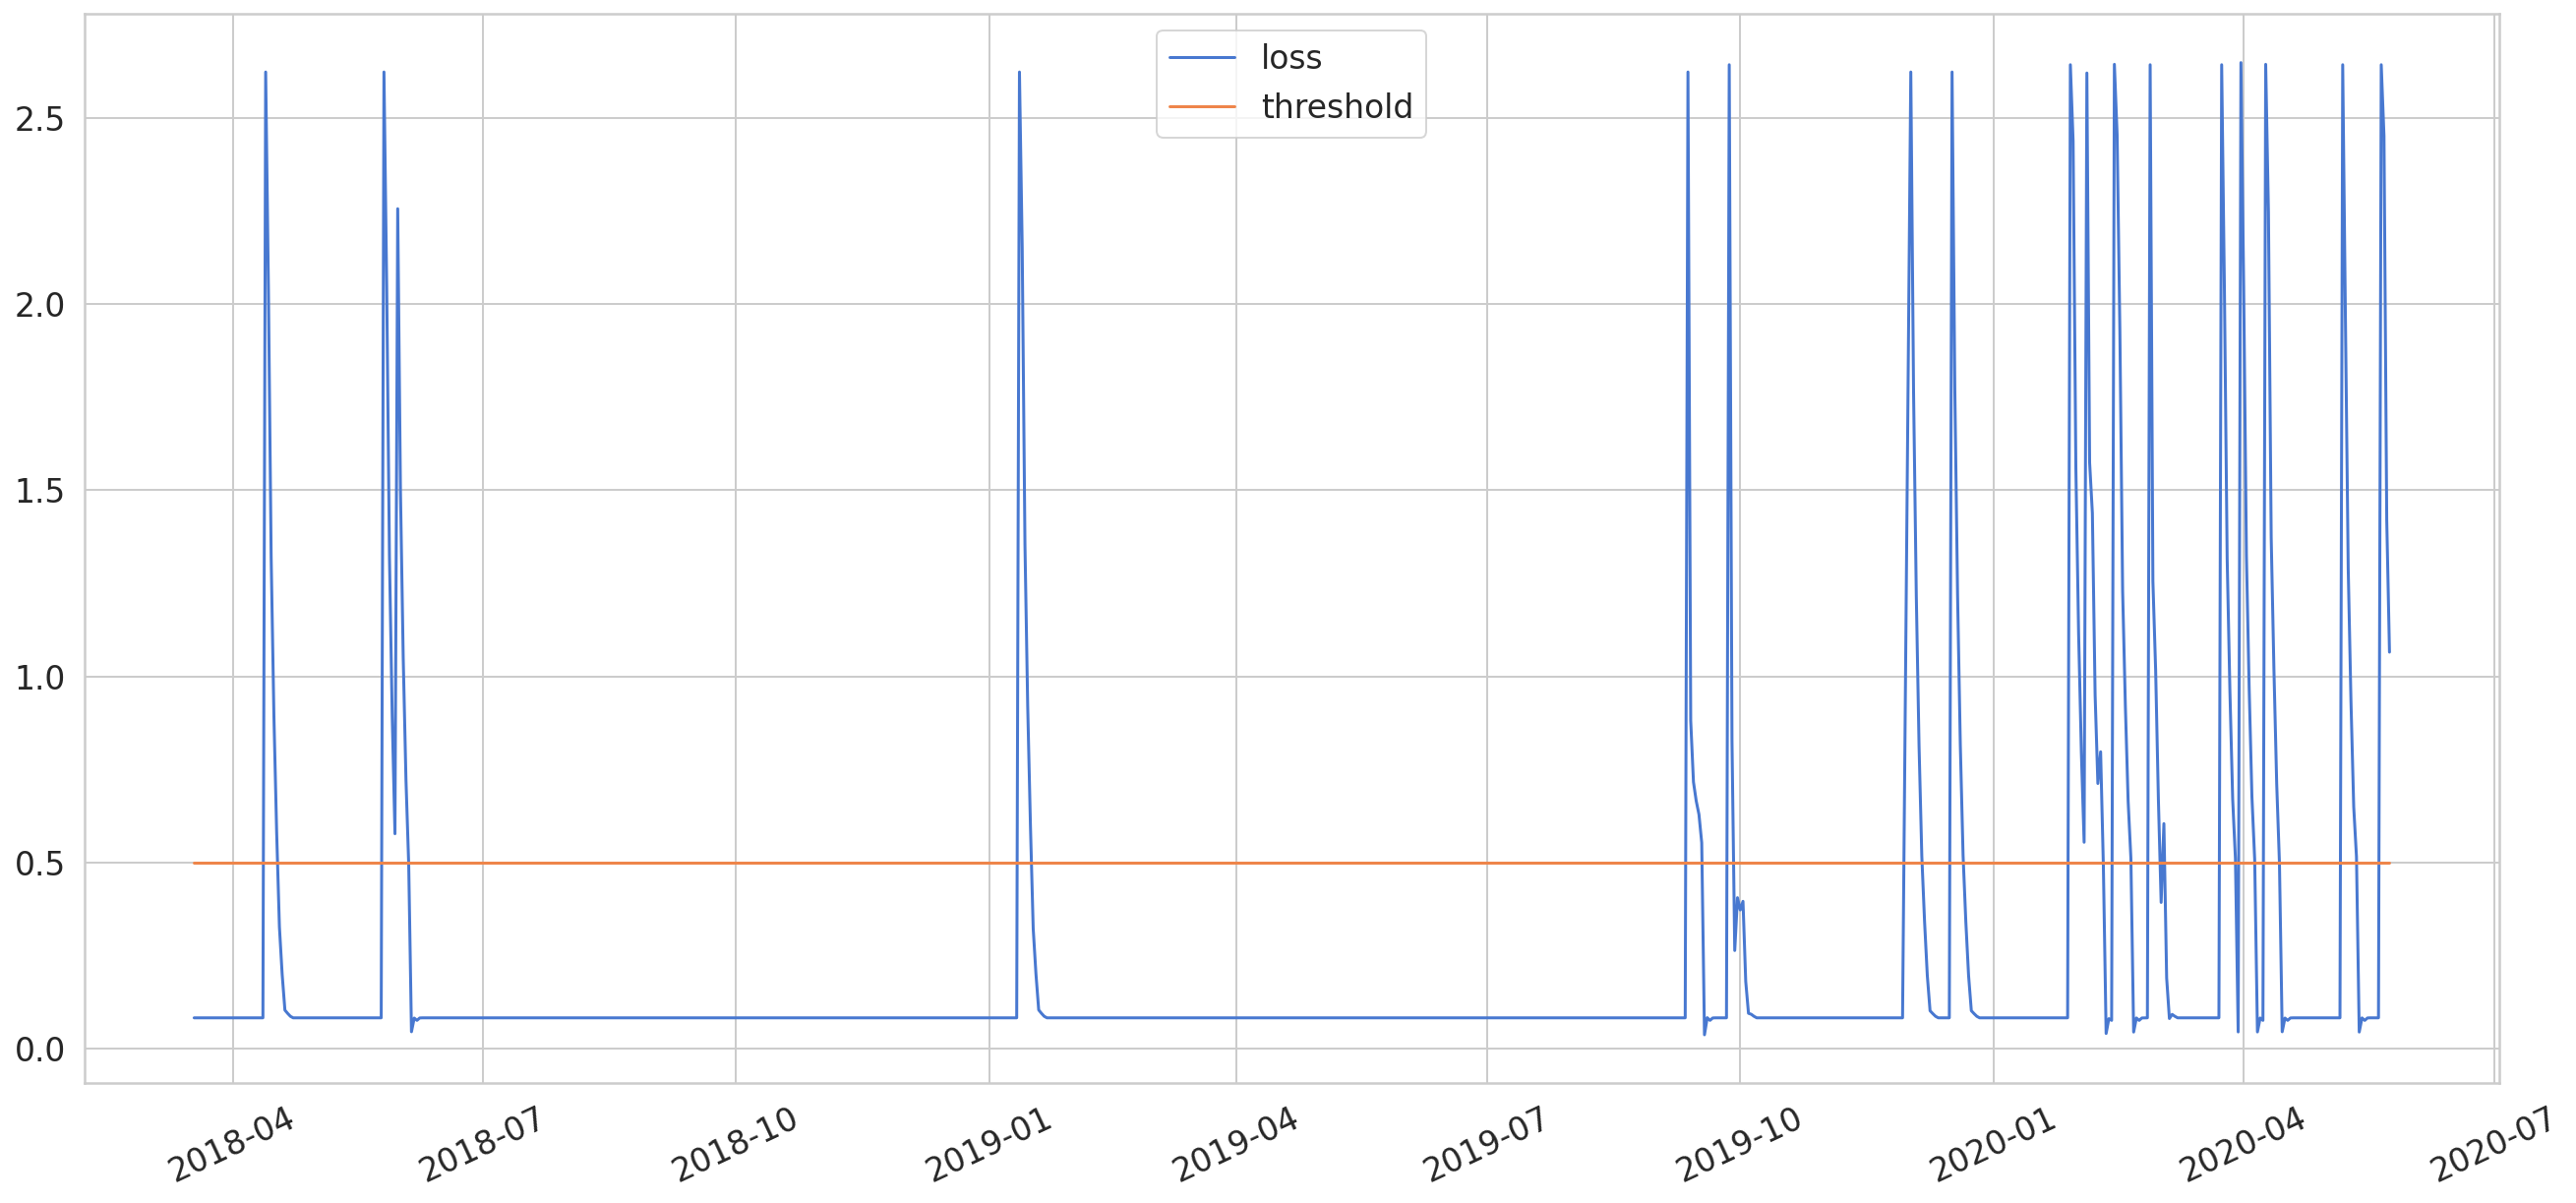

In [269]:
plt.plot(test_score_df.index,test_score_df.loss,label='loss')
plt.plot(test_score_df.index,test_score_df.threshold,label='threshold')
plt.xticks(rotation=25)
plt.legend();


In [270]:
#create anomalies dataset
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,z5,acct_ttl_unit_hours
usage_date,,,,,
2018-04-13 00:00:00+00:00,2.622407,0.5,True,3.136145,24384.0
2018-04-14 00:00:00+00:00,2.042899,0.5,True,2.008717,24384.0
2018-04-15 00:00:00+00:00,1.318990,0.5,True,1.406016,24384.0
2018-04-16 00:00:00+00:00,0.892924,0.5,True,0.970808,24384.0
2018-04-17 00:00:00+00:00,0.580317,0.5,True,0.609286,24384.0


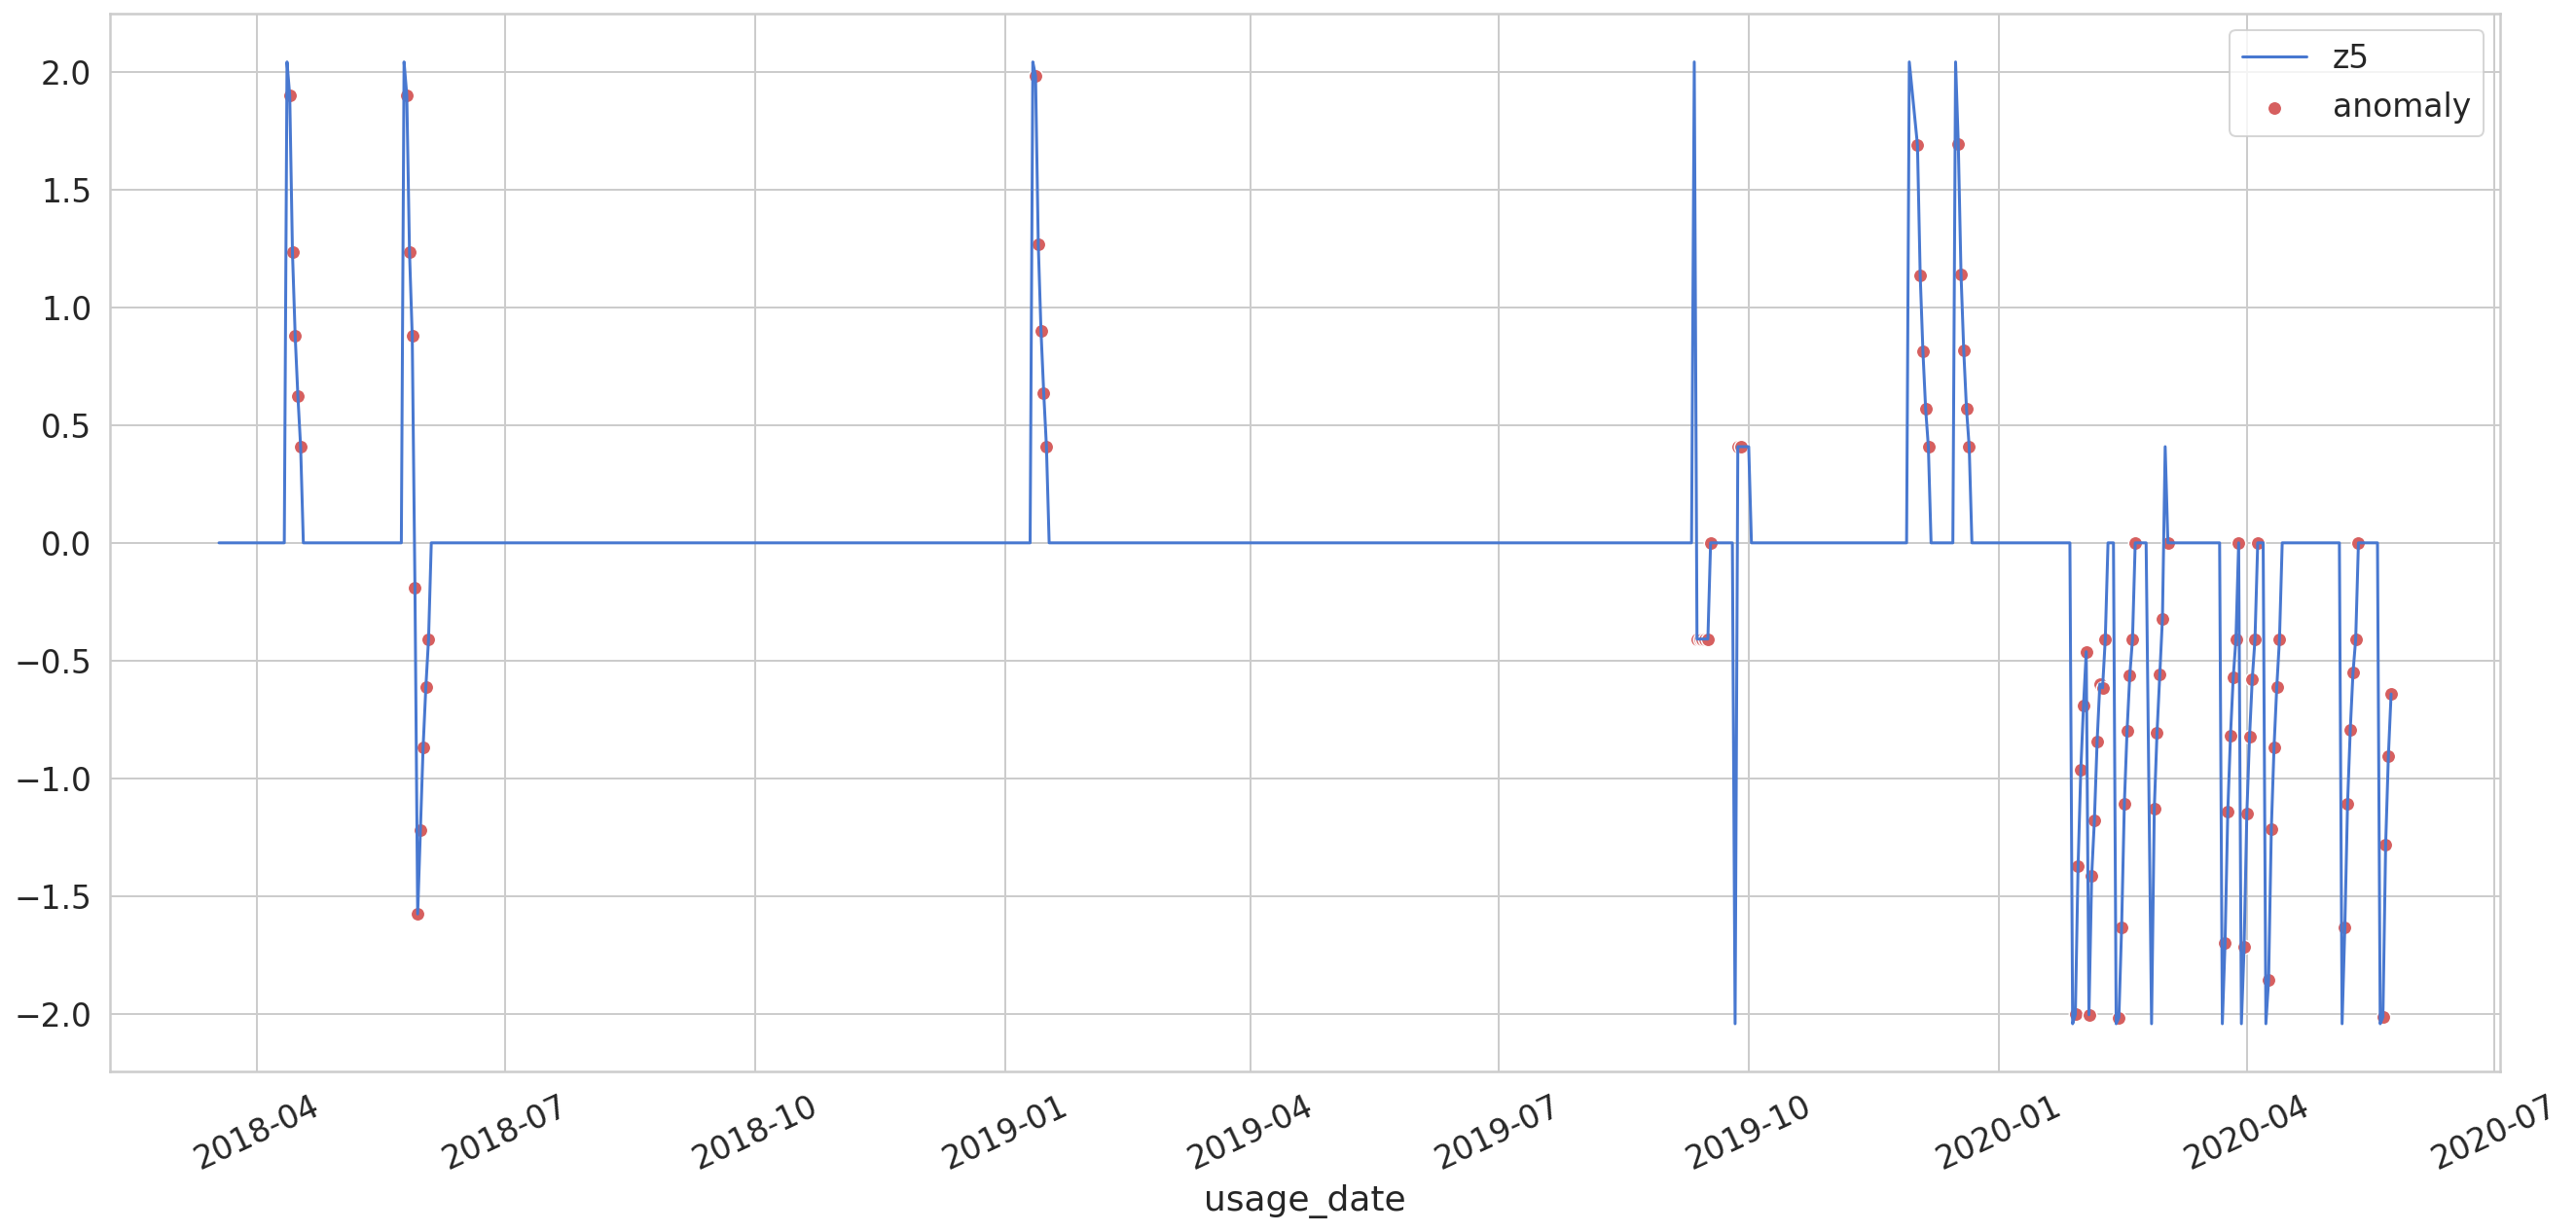

In [271]:
plt.plot(
    test[TIME_STEPS:].index,
    scaler.inverse_transform(test[TIME_STEPS:][poi]),
    label=poi
)

sns.scatterplot(
    anomalies.index,
    scaler.inverse_transform(anomalies[poi]),
    color=sns.color_palette()[3],
    s=52,
    label='anomaly'
)

plt.xticks(rotation=25)
plt.legend();

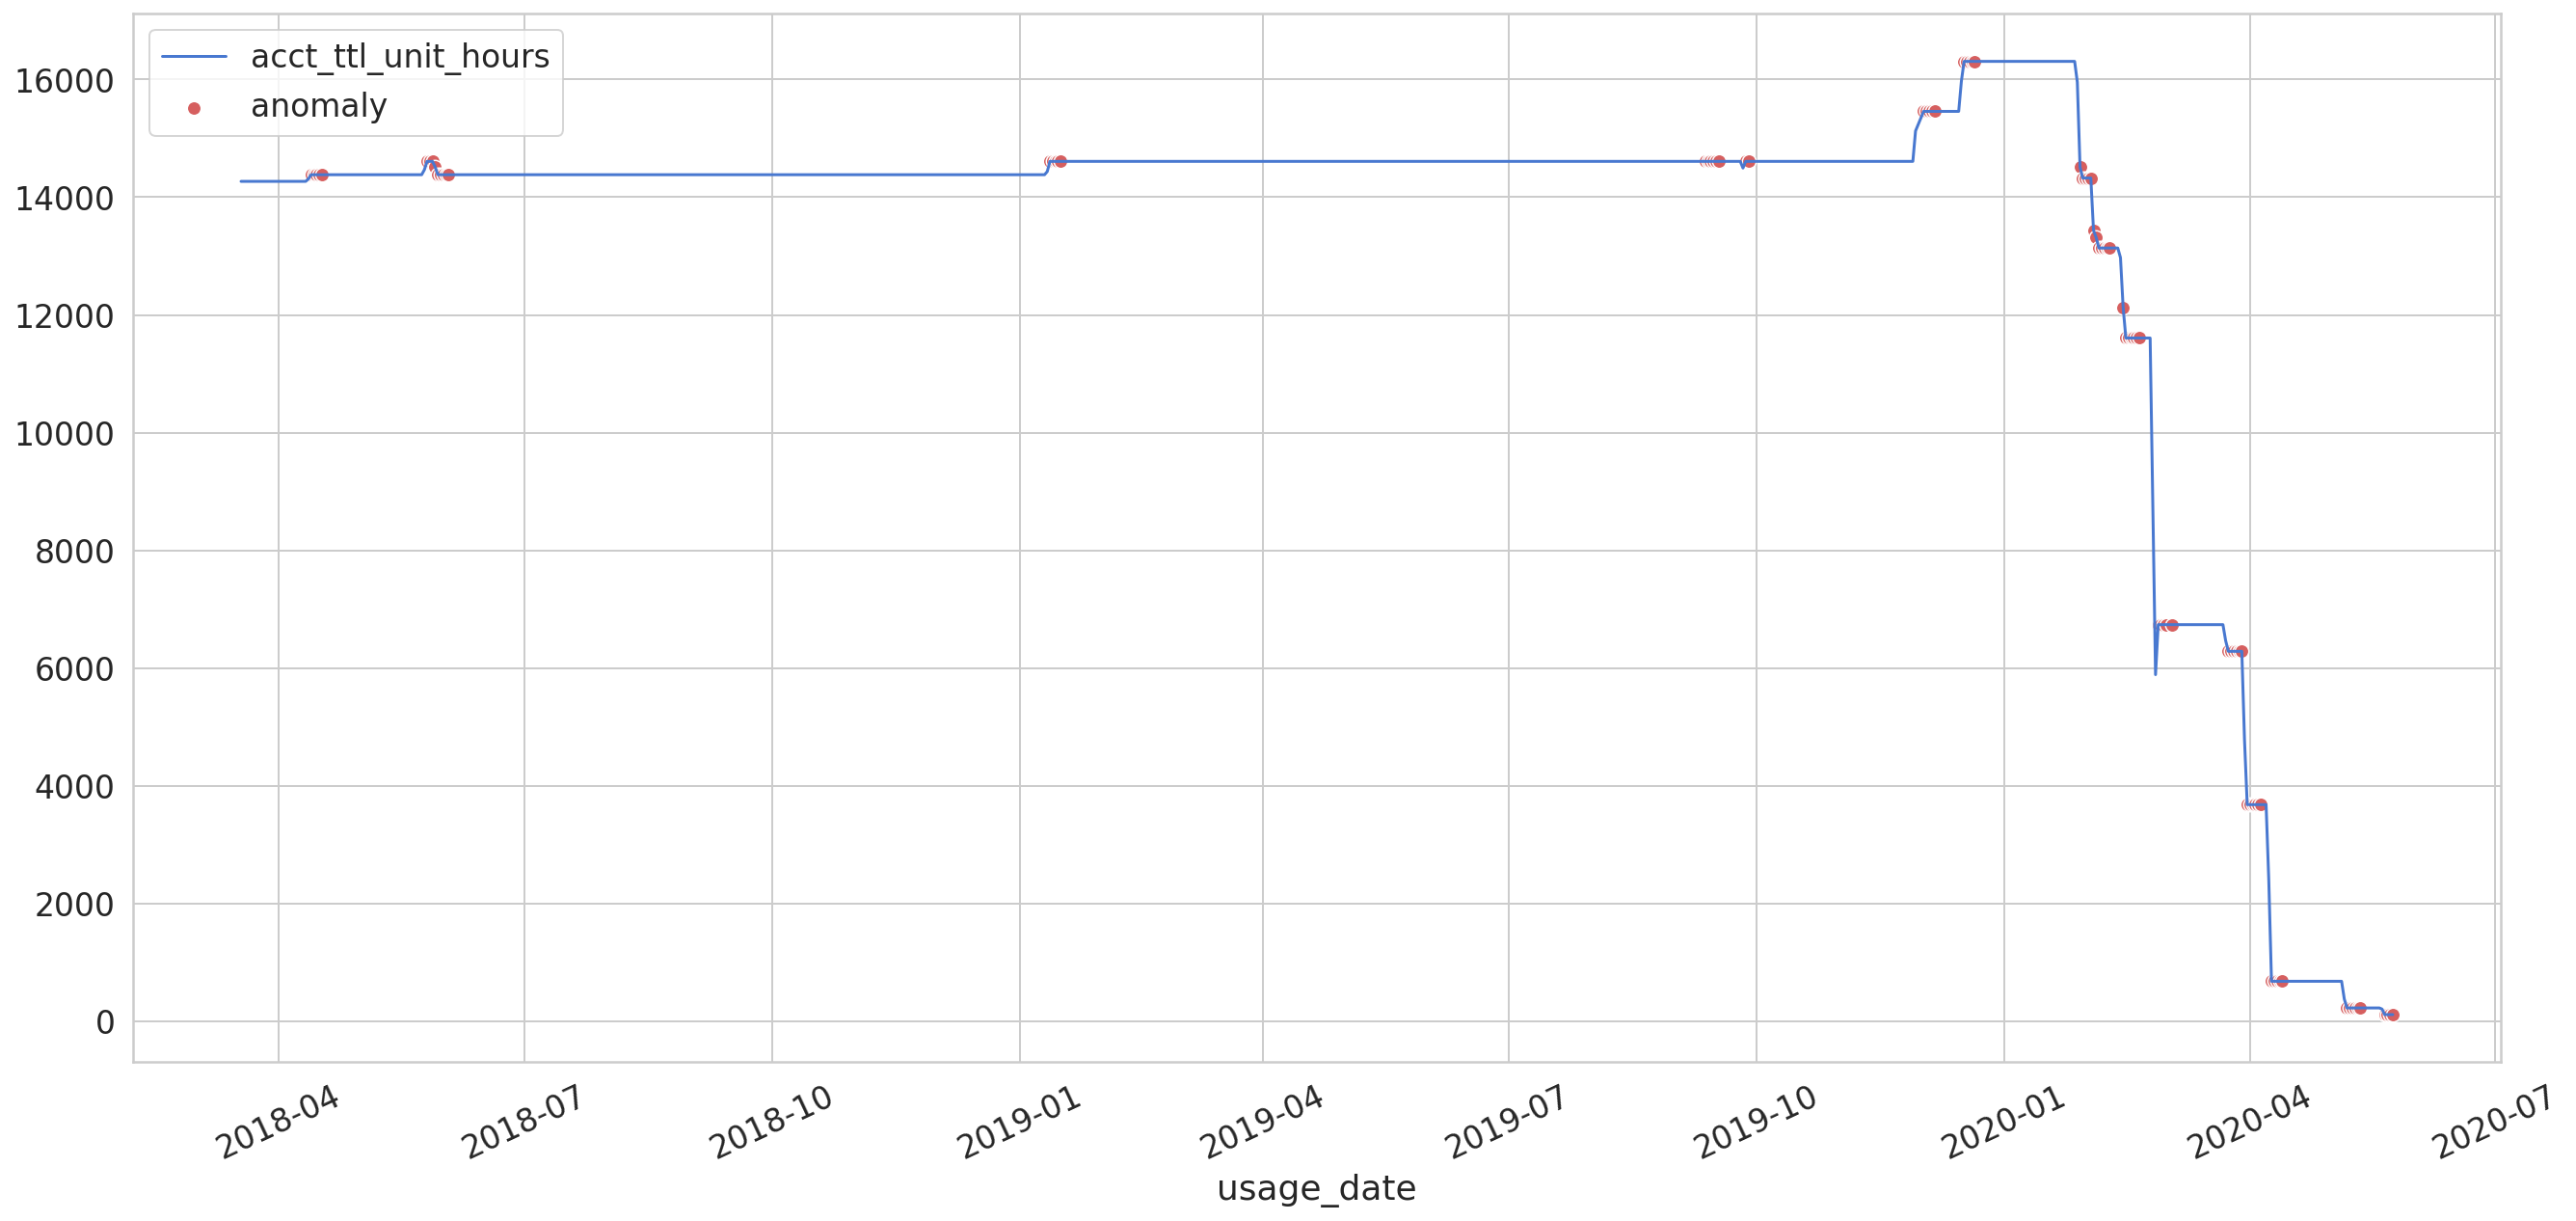

In [272]:
plt.plot(
    test[TIME_STEPS:].index,
    scaler.inverse_transform(test[TIME_STEPS:]['acct_ttl_unit_hours']),
    label='acct_ttl_unit_hours'
)

sns.scatterplot(
    anomalies.index,
    scaler.inverse_transform(anomalies['acct_ttl_unit_hours']),
    color=sns.color_palette()[3],
    s=52,
    label='anomaly'
)

plt.xticks(rotation=25)
plt.legend();